# Regression Tree

It's time to design our generic regression tree model that can be applied to any player. It will be based on the regression tree we designed using Federer as an exemple.

In [44]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We select the player and generate a table containing that player's matches which we will store in "player.csv", as to avoid creating one table for each player.  
Note : This setup step has to be repeated each time we change players.

In [45]:
### CLEAN PLAYER MATCHES TABLES ###

PLAYER = "Novak Djokovic"
setup = False

if (setup) :    # Creating the table (if the player.csv table currently contains information for another player)

    atp = pd.read_csv("atp_cat.csv")

    player_won = atp[atp["winner_name"] == PLAYER]
    player_lost = atp[atp["loser_name"] == PLAYER]

    # We'll drop all of the player's information except his age and rank
    player_won = player_won.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
    player_won = player_won.rename(columns={"winner_age": "player_age", "winner_rank": "player_rank", "winner_rank_points": "player_rank_points",
                                    "loser_name":"opp_name", "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_ioc":"opp_ioc", "loser_age":"opp_age",
                                    "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
    player_won["index2"] = player_won.index
    player_won["player_won"] = "1"

    player_lost = player_lost.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
    player_lost = player_lost.rename(columns={"loser_age": "player_age", "loser_rank": "player_rank", "loser_rank_points": "player_rank_points",
                                        "winner_name":"opp_name", "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_ioc":"opp_ioc", "winner_age":"opp_age",
                                        "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
    player_lost["index2"] = player_lost.index
    player_lost["player_won"] = "0"

    player = pd.concat([player_won, player_lost])
    player = player.drop(["Unnamed: 0", "index2"] , axis=1)
    player.sort_index(inplace=True)

    # Win streaks
    result = player.player_won.astype(int)
    consecutive = result.groupby((result != result.shift()).cumsum()).cumcount()
    wins = pd.DataFrame({"win" : result, "consecutive" : consecutive})
    m = wins.win == 1
    wins.consecutive = wins.consecutive.where(m, 0)
    player["consecutive"] = wins.consecutive

    player.to_csv("player.csv")     # Saving the table for ease of use

else :  # player.csv already contains this player's information

    player = pd.read_csv("player.csv")

display(player)
print(f"{PLAYER} has {len(player)} recorded matches.")

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,tourney_name,surface,tourney_level,tourney_date,player_age,opp_name,opp_hand,...,score,best_of,round,minutes,player_rank,player_rank_points,opp_rank,opp_rank_points,player_won,consecutive
0,0,0,39968,Bangkok,Hard,A,20040927,17.352498,Dennis Van Scheppingen,R,...,4-6 7-5 6-4,3,R32,112.0,248.0,148.0,81.0,496.0,0,0
1,1,1,41582,Umag,Clay,A,20040719,17.160849,Filippo Volandri,R,...,7-6(5) 6-1,3,R32,90.0,368.0,83.0,65.0,630.0,0,0
2,2,2,42684,Bucharest,Clay,A,20040913,17.314168,Arnaud Clement,R,...,2-6 6-4 6-4,3,R32,146.0,272.0,128.0,67.0,623.0,1,0
3,3,3,42693,Bucharest,Clay,A,20040913,17.314168,David Ferrer,R,...,4-6 6-4 6-4,3,R16,155.0,272.0,128.0,54.0,714.0,0,0
4,4,4,43520,Paris Masters,Carpet,M,20051031,18.444901,Victor Hanescu,R,...,4-1 RET,3,R64,19.0,85.0,488.0,37.0,853.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,1088,1088,86190,Us Open,Hard,G,20210830,34.275154,Kei Nishikori,R,...,6-7(4) 6-3 6-3 6-2,5,R32,212.0,1.0,11113.0,56.0,1208.0,1,24
1089,1089,1089,86206,Us Open,Hard,G,20210830,34.275154,Jenson Brooksby,R,...,1-6 6-3 6-2 6-2,5,R16,179.0,1.0,11113.0,99.0,812.0,1,25
1090,1090,1090,86214,Us Open,Hard,G,20210830,34.275154,Matteo Berrettini,R,...,5-7 6-2 6-2 6-3,5,QF,207.0,1.0,11113.0,8.0,5533.0,1,26
1091,1091,1091,86218,Us Open,Hard,G,20210830,34.275154,Alexander Zverev,R,...,4-6 6-2 6-4 4-6 6-2,5,SF,214.0,1.0,11113.0,4.0,8240.0,1,27


Novak Djokovic has 1093 recorded matches.


In [46]:


player.to_csv("player.csv")

player.tail(5)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,tourney_name,surface,tourney_level,tourney_date,player_age,opp_name,opp_hand,...,score,best_of,round,minutes,player_rank,player_rank_points,opp_rank,opp_rank_points,player_won,consecutive
1088,1088,1088,86190,Us Open,Hard,G,20210830,34.275154,Kei Nishikori,R,...,6-7(4) 6-3 6-3 6-2,5,R32,212.0,1.0,11113.0,56.0,1208.0,1,24
1089,1089,1089,86206,Us Open,Hard,G,20210830,34.275154,Jenson Brooksby,R,...,1-6 6-3 6-2 6-2,5,R16,179.0,1.0,11113.0,99.0,812.0,1,25
1090,1090,1090,86214,Us Open,Hard,G,20210830,34.275154,Matteo Berrettini,R,...,5-7 6-2 6-2 6-3,5,QF,207.0,1.0,11113.0,8.0,5533.0,1,26
1091,1091,1091,86218,Us Open,Hard,G,20210830,34.275154,Alexander Zverev,R,...,4-6 6-2 6-4 4-6 6-2,5,SF,214.0,1.0,11113.0,4.0,8240.0,1,27
1092,1092,1092,86220,Us Open,Hard,G,20210830,34.275154,Daniil Medvedev,R,...,6-4 6-4 6-4,5,F,136.0,1.0,11113.0,2.0,9980.0,0,0


## Regression Decision Tree

We will create a decision tree using these features :
- Surface  
- Best of  
- Opponent hand  
- Opponent height  
- Opponent country  
- Ranking difference  
- Tournament level  
- Match round (QF, SF, F, etc...)
- Player form  

Some of these features seem irrelevant, and they probably are. However, since we will use GridSearchCV to perform feature selection, we will feed the model all the information we have and let it select what is important (ie. the optimal splits in terms of information gain).

### Formatting

The "player.csv" table contains many unecessary columns. Here, we create a player1 table containing all the features we potentially need for our model and format them correctly. Specifically, we use one-hot encoding to split categorical data into multiple boolean columns.

In [47]:
player1 = player[["minutes", "surface", "best_of", "opp_hand", "opp_ht", "opp_age", "tourney_level", "round"]]
player1["rank_diff"] = player["player_rank"] - player["opp_rank"]
player1["consecutive"] = player["consecutive"]

# One-Hot Encoding
player1 = pd.get_dummies(data=player1, columns=["surface", "best_of", "opp_hand", "tourney_level", "round"])

player1 = player1.dropna(axis=0, how='any')

player1.head(5)

C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,minutes,opp_ht,opp_age,rank_diff,consecutive,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,best_of_3,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,112.0,185.0,29.232033,167.0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
1,90.0,183.0,22.869268,303.0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,146.0,173.0,26.740589,205.0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,155.0,175.0,22.450376,218.0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,19.0,198.0,24.279261,48.0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


### Regression Decision Tree



#### Pre-processing

For pre-processing we have three options :
- not scaling x or y
- scaling both x and y
- scaling x but not y   
  
I feel like scaling gives us better results but adds a hurdle in interpreting the tree's visualization since it displays scaled values. We can scale both input and output values back, just not display them with sklearns's plot_tree (or any tree visualization that I've found so far). For now, the roundabout solution is just to print out the scaled input and output.

In [48]:
### PRE-PROCESSING ###

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target='minutes'

scale_x = False
scale_y = False

def preprocessing(scale_x=False, scale_y=False) :

    # 1. X, y unscaled
    X = player1.drop([target], axis=1)
    y = np.asarray(player1[target])
    y = y.reshape(-1,1)

    xscaler = StandardScaler()
    yscaler = StandardScaler()

    if (scale_x) :
        print("Scaling X...")
        xscaler.fit(X[['opp_ht', 'opp_age', 'rank_diff']])
        X[['opp_ht', 'opp_age', 'rank_diff']] = xscaler.transform(X[['opp_ht', 'opp_age', 'rank_diff']])

    if (scale_y) :
        print("Scaling y...")
        yscaler.fit(y)
        y = yscaler.transform(y)

    display(pd.DataFrame(X).head())
    display(pd.DataFrame(y).head())

    return X, y, xscaler, yscaler

X, y, xscaler, yscaler = preprocessing(scale_x, scale_y)

,opp_ht,opp_age,rank_diff,consecutive,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185.0,29.232033,167.0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,183.0,22.869268,303.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,173.0,26.740589,205.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,175.0,22.450376,218.0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,198.0,24.279261,48.0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


,0
0,112.0
1,90.0
2,146.0
3,155.0
4,19.0


#### Building the tree

To build a good tree, we need to select values for the tree's parameters (e.g. max depth, minimum samples per leaf). We'll perform this "Hyperparameter Tuning" using GridSearchCV, a library which selects the best tree by trying every combination of parameters we give it and performing a cross validation. The trees are commpared based on the R² criteria.  
  
![score formula](res/score.png "sklearn score")  

In [49]:
### PARAMETER SELECTION ###

from sklearn.model_selection import GridSearchCV

params = {
    # "criterion":("squared_error", "friedman_mse", "absolute_error", "poisson"), 
    "max_depth":np.arange(3, 10), 
    "min_samples_leaf":np.arange(1, 80), 
    # "min_weight_fraction_leaf":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001], 
    # "max_features":np.arange(1, 25)
}

dtr = DecisionTreeRegressor(random_state=42)
dtr_cv = GridSearchCV(dtr, params, scoring="r2", n_jobs=-1, verbose=1, cv=10)

In [50]:
### CUSTOM PREDICTION ###

def custom_predict(dtr, scale_x, scale_y, height, age, rank_diff, consecutive, surface, best_of, hand, level, round) :
    # returns the predicted length of a match given a set of match conditions

    # surface : carpet(1), clay(2), grass(3), hard(4)
    # best of : 3(1), 5(2)
    # hand : left(1), right(2)
    # level : A(1), D(2), F(3), G(4), M(5)
    # round : F(1), QF(2), R128(3), R16(4), R32(5), R64(6), R(7), SF(8)

    surface_input = [0, 0, 0, 0]
    surface_input[surface - 1] = 1

    bo_input = [0, 0]
    bo_input[best_of - 1] = 1

    hand_input = [0, 0]
    hand_input[hand - 1] = 1

    level_input = [0, 0, 0, 0, 0]
    level_input[level - 1] = 1

    round_input = [0, 0, 0, 0, 0, 0, 0, 0]
    round_input[round - 1] = 1

    if (not scale_x and not scale_y) :  # 1. X, y unscaled
        input = [height, age, rank_diff] + [consecutive] + surface_input + bo_input + hand_input + level_input + round_input
        print("Input : ", input)

        input = [input]

        print("Prediction : ", dtr.predict(input), " minutes")

    # input = [180, 0, 0, 0, 1, 0, 0, 0, 1]

    elif (scale_x and scale_y) :    # 2. X, y scaled
        input = xscaler.transform([[height, age, rank_diff]])
        input = np.append(input[0], consecutive, surface_input + bo_input + hand_input + level_input + round_input)
        print("Scaled input : ", input)

        input = [input]

        print("Scaled Prediction : ", dtr.predict(input), " minutes")
        print("Prediction : ", yscaler.inverse_transform(dtr.predict(input)), " minutes")

    elif (scale_x and not scale_y) :    # 3. X scaled, y unscaled
        input = xscaler.transform([[height, age, rank_diff]]).tolist()
        input = np.append(input[0], [consecutive] + surface_input + bo_input + hand_input + level_input + round_input)
        print("Scaled input : ", input)
        
        input = [input]

        print("Prediction : ", dtr.predict(input)[0], " minutes")

    return(dtr.predict(input)[0])

# prediction = predict(scale_x, scale_y, 180, 22, 0, 0, 4, 1, 2, 4, 5)

In [51]:
### THE LOOP ###

test_scores = []
predictions = []

iter = 100

for i in range(iter) :

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.3)
    dtr_cv.fit(Xtrain, ytrain)

    best_params = dtr_cv.best_params_
    print(f"Best parameters: {best_params})")

    dtr = DecisionTreeRegressor(**best_params)
    dtr.fit(Xtrain, ytrain)

    # Testing :

    ypred = dtr.predict(Xtest)

    print(f"Training score {i+1} : ", dtr.score(Xtrain, ytrain))
    print(f"Testing score {i+1} : ", dtr.score(Xtest, ytest))
    test_scores.append(dtr.score(Xtest, ytest))

    predictions.append(custom_predict(dtr, scale_x, scale_y, 180, 22, 10, 0, 4, 1, 2, 4, 5))

print("------------------------------------------------------------------------------------------------")
print("Test scores : ", test_scores)
print("Test scores average : ", sum(test_scores)/len(test_scores))

print("------------------------------------------------------------------------------------------------")
print(predictions)
print(f"Average predicted length : {sum(predictions) / len(predictions)}")

Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 4552 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   25.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 15})
Training score 1 :  0.3719853136224822
Testing score 1 :  0.2487002992841284
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.02614379]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 77})
Training score 2 :  0.32545836143619267
Testing score 2 :  0.29015671798213305
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [170.84166667]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 35})
Training score 3 :  0.36400346596719446
Testing score 3 :  0.30855063640670355
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [105.]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 53})
Training score 4 :  0.355661547958372
Testing score 4 :  0.2403988054834475
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [101.81132075]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 33})
Training score 5 :  0.36290278615305216
Testing score 5 :  0.3003493122014572
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [119.42857143]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 79})
Training score 6 :  0.30611799923340566
Testing score 6 :  0.3064844777476632
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [117.4]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 52})
Training score 7 :  0.3373221584792305
Testing score 7 :  0.3052138936805632
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.78461538]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 54})
Training score 8 :  0.34561381253753753
Testing score 8 :  0.28146115437858077
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.36363636]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 77})
Training score 9 :  0.3199824044315721
Testing score 9 :  0.30876019180446734
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.61864407]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 8})
Training score 10 :  0.35317658781269323
Testing score 10 :  0.32308313409912315
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [111.38356164]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 55})
Training score 11 :  0.34919713648615036
Testing score 11 :  0.2561024940593205
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [181.21126761]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 40})
Training score 12 :  0.34770776843512596
Testing score 12 :  0.27939533334612954
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [180.63291139]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 7})
Training score 13 :  0.3581379954818419
Testing score 13 :  0.2720424808487816
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [109.8974359]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4808 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 44})
Training score 14 :  0.34514108553563827
Testing score 14 :  0.2838429894081599
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [109.64539007]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 7})
Training score 15 :  0.3527127824228794
Testing score 15 :  0.3034328061752637
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [105.45098039]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.9s finished


Best parameters: {'max_depth': 4, 'min_samples_leaf': 56})
Training score 16 :  0.3420008478338774
Testing score 16 :  0.2580565195060597
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [113.53947368]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 38})
Training score 17 :  0.3385669579039655
Testing score 17 :  0.3134569910814361
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.17567568]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 21})
Training score 18 :  0.4035604954124711
Testing score 18 :  0.25893182558952177
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [136.25]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 27})
Training score 19 :  0.3718185251495506
Testing score 19 :  0.2743881868314918
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.38317757]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 10})
Training score 20 :  0.35823338201948307
Testing score 20 :  0.3099729307778102
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [106.88741722]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 20})
Training score 21 :  0.34363070864948997
Testing score 21 :  0.2767852231426683
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [111.80921053]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 55})
Training score 22 :  0.39706319938680557
Testing score 22 :  0.08033371592513594
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [192.30909091]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 64})
Training score 23 :  0.3086716859129488
Testing score 23 :  0.32510398660633055
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [118.7962963]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 10})
Training score 24 :  0.3481538164050748
Testing score 24 :  0.319753537917842
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.41290323]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   25.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 42})
Training score 25 :  0.37999834828825163
Testing score 25 :  0.22563888475308025
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.62820513]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 20})
Training score 26 :  0.3480471223654409
Testing score 26 :  0.3079758618845483
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.66891892]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 79})
Training score 27 :  0.29899244377457657
Testing score 27 :  0.3494331490383973
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [115.3956044]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 3})
Training score 28 :  0.3997431505724923
Testing score 28 :  0.20186526061467125
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.7672956]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 41})
Training score 29 :  0.38209501401667634
Testing score 29 :  0.17135451524558498
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [194.37777778]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 51})
Training score 30 :  0.3328281627042955
Testing score 30 :  0.3005075707911229
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [179.5483871]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 15})
Training score 31 :  0.3497208546652246
Testing score 31 :  0.2953688395353663
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [109.42567568]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 56})
Training score 32 :  0.3465023579374372
Testing score 32 :  0.29707542452347635
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [112.31578947]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 32})
Training score 33 :  0.37461704889318326
Testing score 33 :  0.23155520445074695
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [182.57692308]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 37})
Training score 34 :  0.3758370045191166
Testing score 34 :  0.1621254871022786
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [112.49668874]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 67})
Training score 35 :  0.31181009273146276
Testing score 35 :  0.334200365290087
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.5308642]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 43})
Training score 36 :  0.3736479102923196
Testing score 36 :  0.23454837095061487
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [104.34782609]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 43})
Training score 37 :  0.34406529229644434
Testing score 37 :  0.30575811937635244
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [109.02580645]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 23})
Training score 38 :  0.38584004832730456
Testing score 38 :  0.24704394954814202
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [109.152]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 17})
Training score 39 :  0.34652031026084396
Testing score 39 :  0.30497122691118017
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [109.32484076]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 17})
Training score 40 :  0.34693067899437235
Testing score 40 :  0.2964797447518629
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.47540984]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 18})
Training score 41 :  0.3430567792822198
Testing score 41 :  0.3303412800115002
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.46666667]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 14})
Training score 42 :  0.3685001565338599
Testing score 42 :  0.24323467587739822
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.97315436]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 18})
Training score 43 :  0.3825157960529839
Testing score 43 :  0.26221048262627755
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [146.26086957]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 35})
Training score 44 :  0.39134514532922104
Testing score 44 :  0.13475563687033432
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [105.6031746]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 2})
Training score 45 :  0.3650574852562669
Testing score 45 :  0.294973633477696
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [105.86896552]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 39})
Training score 46 :  0.363032945086051
Testing score 46 :  0.2748000789082228
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.96969697]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 79})
Training score 47 :  0.33852704469150074
Testing score 47 :  0.2612219514884989
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [174.83333333]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 37})
Training score 48 :  0.3547106322955689
Testing score 48 :  0.19402789555876054
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [163.25352113]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 56})
Training score 49 :  0.3415378237882224
Testing score 49 :  0.3169912165579355
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [111.12676056]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   21.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 44})
Training score 50 :  0.35115203917504534
Testing score 50 :  0.2713395995059258
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [104.89565217]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 70})
Training score 51 :  0.36582356676096905
Testing score 51 :  0.20968901830906916
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [171.80672269]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 49})
Training score 52 :  0.30307391104344483
Testing score 52 :  0.3427546173178915
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.65753425]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   19.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 39})
Training score 53 :  0.3229585890967859
Testing score 53 :  0.35174095784240844
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.72297297]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 16})
Training score 54 :  0.3431917902558803
Testing score 54 :  0.32635711523507516
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.96153846]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   26.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 53})
Training score 55 :  0.306777850920135
Testing score 55 :  0.39878195214855294
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [106.59722222]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   28.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 21})
Training score 56 :  0.36351589342465596
Testing score 56 :  0.249894542639428
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.59235669]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   24.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 5})
Training score 57 :  0.36039162838809935
Testing score 57 :  0.2659605819248816
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [109.51904762]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   29.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 29})
Training score 58 :  0.36567436855357793
Testing score 58 :  0.25074828715277075
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [142.93103448]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   27.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 56})
Training score 59 :  0.30392759035696515
Testing score 59 :  0.37775331586801564
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [113.109375]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   29.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 36})
Training score 60 :  0.3665021669680033
Testing score 60 :  0.26587952621516564
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [106.24528302]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   27.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   27.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 1})
Training score 61 :  0.3455038175241081
Testing score 61 :  0.3337301985136295
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [113.85714286]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 29})
Training score 62 :  0.3588168646490868
Testing score 62 :  0.31825262196491855
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [101.65853659]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   26.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 33})
Training score 63 :  0.36776919702779476
Testing score 63 :  0.260410426095393
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [105.10434783]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   29.5s finished


Best parameters: {'max_depth': 3, 'min_samples_leaf': 31})
Training score 64 :  0.3307701106147408
Testing score 64 :  0.3193941695275945
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [104.72302158]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   31.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   31.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 20})
Training score 65 :  0.35618065892195205
Testing score 65 :  0.3031350042923866
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.53521127]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   30.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   30.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 55})
Training score 66 :  0.31440419812891707
Testing score 66 :  0.36998148347691706
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.90625]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   31.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 48})
Training score 67 :  0.3535078589400086
Testing score 67 :  0.28068606607260893
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [113.65671642]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   25.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 42})
Training score 68 :  0.37940414298183145
Testing score 68 :  0.24987490618390595
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [179.83783784]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   29.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 47})
Training score 69 :  0.3638774075549268
Testing score 69 :  0.2572755962888761
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [105.82222222]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   30.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 31})
Training score 70 :  0.3659504157757977
Testing score 70 :  0.2757337170414479
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [97.65625]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   29.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   30.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 1})
Training score 71 :  0.3802125233157013
Testing score 71 :  0.2787180210905741
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.6442953]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   28.6s finished


Best parameters: {'max_depth': 3, 'min_samples_leaf': 17})
Training score 72 :  0.3365643897571411
Testing score 72 :  0.28494364080500056
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [116.06557377]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   31.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 19})
Training score 73 :  0.3348842100927266
Testing score 73 :  0.34461683923712494
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.19354839]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   30.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 73})
Training score 74 :  0.3391801629343155
Testing score 74 :  0.27556601927125124
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [115.60869565]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   26.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 5})
Training score 75 :  0.38370174718249106
Testing score 75 :  0.27727915285756144
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.93877551]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   26.9s finished


Best parameters: {'max_depth': 3, 'min_samples_leaf': 28})
Training score 76 :  0.3702447888899172
Testing score 76 :  0.2598690609955516
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [184.97014925]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   26.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   27.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 15})
Training score 77 :  0.3480019475108381
Testing score 77 :  0.294760137480946
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [109.23684211]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   30.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 68})
Training score 78 :  0.3179827508033676
Testing score 78 :  0.3397463437262256
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.40458015]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   28.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   28.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 64})
Training score 79 :  0.36505888051458935
Testing score 79 :  0.22936186156661031
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [115.2]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   27.7s finished


Best parameters: {'max_depth': 3, 'min_samples_leaf': 10})
Training score 80 :  0.3651680213993497
Testing score 80 :  0.23842390894268617
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [103.34453782]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   29.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   29.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 6, 'min_samples_leaf': 39})
Training score 81 :  0.3864823621909148
Testing score 81 :  0.21331872870974944
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [181.6]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   31.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   31.3s finished


Best parameters: {'max_depth': 4, 'min_samples_leaf': 46})
Training score 82 :  0.3319639347640865
Testing score 82 :  0.3300426609457058
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [114.07272727]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   31.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 62})
Training score 83 :  0.3708287693948107
Testing score 83 :  0.23743836690889664
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [182.24675325]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   30.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 51})
Training score 84 :  0.34436179918280496
Testing score 84 :  0.2598475823582431
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.24460432]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   27.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 44})
Training score 85 :  0.3521773533776267
Testing score 85 :  0.2794281054048313
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.28289474]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   26.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 7})
Training score 86 :  0.3869754087073064
Testing score 86 :  0.26605019025379106
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [120.]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   29.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 46})
Training score 87 :  0.33830794484693216
Testing score 87 :  0.307250595766265
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [178.02]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   30.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   30.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 45})
Training score 88 :  0.3481187241977617
Testing score 88 :  0.2689825661835571
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.02112676]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1620 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3020 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 4820 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   31.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 45})
Training score 89 :  0.3356624532510617
Testing score 89 :  0.3243777073351174
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.34591195]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 62})
Training score 90 :  0.3152760962893011
Testing score 90 :  0.33357904841295904
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [106.34117647]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   27.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 53})
Training score 91 :  0.34719053643814834
Testing score 91 :  0.3045434324668166
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [117.12857143]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   30.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   30.3s finished


Best parameters: {'max_depth': 3, 'min_samples_leaf': 13})
Training score 92 :  0.3438322746345148
Testing score 92 :  0.3010307591882343
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [106.62195122]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 3144 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   26.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 93 :  0.36801409486188974
Testing score 93 :  0.2578086456572872
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [106.1986755]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   26.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 60})
Training score 94 :  0.2967174235797083
Testing score 94 :  0.4372919432403535
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [110.13043478]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   30.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   30.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 76})
Training score 95 :  0.29105635269364194
Testing score 95 :  0.3524993520565839
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [115.15447154]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   26.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 26})
Training score 96 :  0.36677036410725317
Testing score 96 :  0.2654298638731418
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.06]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   28.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 71})
Training score 97 :  0.3377613617901043
Testing score 97 :  0.2492963725471118
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [109.48360656]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   29.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   29.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 29})
Training score 98 :  0.39875791334933
Testing score 98 :  0.20696621861290332
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [95.43333333]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 5515 out of 5530 | elapsed:   30.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   30.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 2})
Training score 99 :  0.35049476596923135
Testing score 99 :  0.26358057722849204
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [119.49710983]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   16.3s


Best parameters: {'max_depth': 5, 'min_samples_leaf': 61})
Training score 100 :  0.3692855892607042
Testing score 100 :  0.16639598974337355
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [167.47540984]  minutes
------------------------------------------------------------------------------------------------
Test scores :  [0.2487002992841284, 0.29015671798213305, 0.30855063640670355, 0.2403988054834475, 0.3003493122014572, 0.3064844777476632, 0.3052138936805632, 0.28146115437858077, 0.30876019180446734, 0.32308313409912315, 0.2561024940593205, 0.27939533334612954, 0.2720424808487816, 0.2838429894081599, 0.3034328061752637, 0.2580565195060597, 0.3134569910814361, 0.25893182558952177, 0.2743881868314918, 0.3099729307778102, 0.2767852231426683, 0.08033371592513594, 0.32510398660633055, 0.319753537917842, 0.22563888475308025, 0.3079758618845483, 0.3494331490383973, 0.20186526061467125, 0.17135451524558498, 0.3005075707911229, 0.295368

[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   28.0s finished


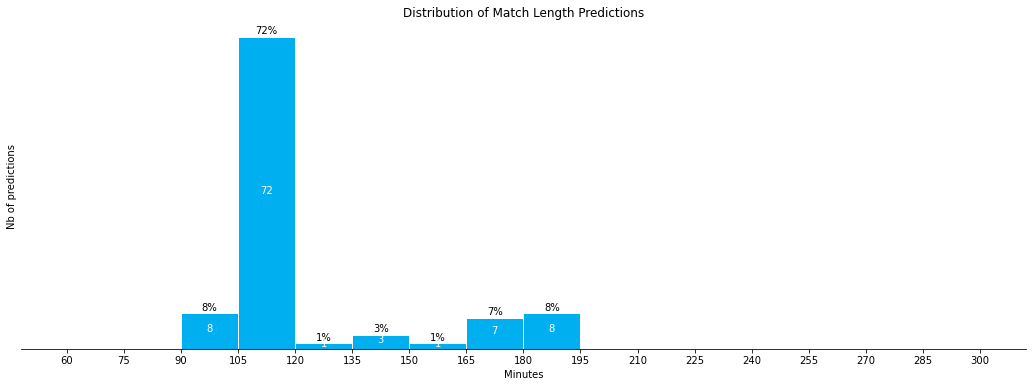

In [54]:
### HISTOGRAM ###

# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0

time_step = 15  # precision : 15/30/30 minutes
intervals=np.arange(60, 300 + time_step, time_step)

fig, ax = plt.subplots(1, figsize=(18,6))

n, bins, patches = plt.hist(predictions, bins=intervals, color='#00AFF0')

plt.xticks(bins)
plt.grid(color='white', lw = 1, axis='x')

plt.title('Distribution of Match Length Predictions')
plt.xlabel("Minutes")
plt.ylabel("Nb of predictions")

# ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
plt.yticks([])

for idx, value in enumerate(n) :
    if value > 0 :
        plt.text(xticks[idx], value + 1, f"{int(100 * value / iter)}%", ha='center')
        plt.text(xticks[idx], value / 2, int(value), ha='center', color='w')

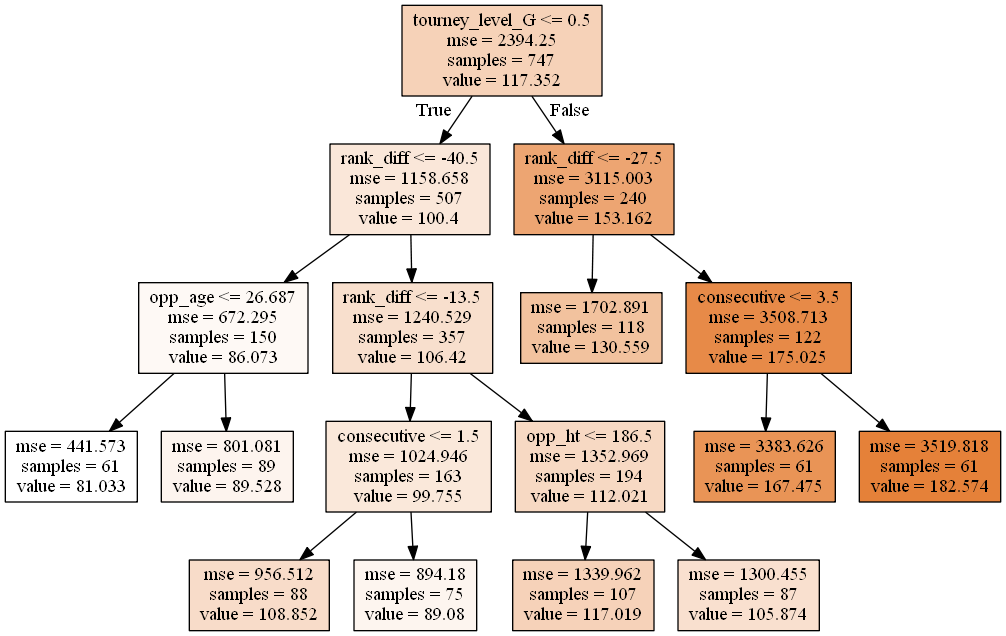

In [53]:
# TREE VISUALIZATION

# Without True/False (sklearn)

# x_ax = range(len(ytest))
# plt.plot(x_ax, ytest, linewidth=1, label="original")
# plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
# plt.title("Y-test and y-predicted data")
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend(loc='best',fancybox=True, shadow=True)
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(30,15))
# tree.plot_tree(dtr,
#           filled=True,
#           rounded=True,
#           fontsize=10,
#           feature_names=["opp_ht", "opp_age", "rank_diff", "consecutive", "surface_Carpet", "surface_Clay", "surface_Grass", "surface_Hard", 
#                          "best_of_3", "best_of_5", "opp_hand_L", "opp_hand_R", 
#                          'tourney_level_A', 'tourney_level_D', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M', 
#                          'round_F', 'round_QF', 'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF'])

# # plt.savefig('tree_high_dpi', dpi=600)

# # With True/False label (pydot)

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

# def visualize_tree(dtr) :

features = list(player1.columns)
features.remove("minutes")

dot_data = StringIO()
export_graphviz(dtr, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

# visualize_tree(dtr)